<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-filip-martin/blob/main/Noise_recognition_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Základní klasifikace - malý dataset, 128x128
Slouží k nastavení základního fungování

## Validace dat
Ověření, že data z hlediska formátu obsahují vše co mají a po vizuální stránkce vypadají "normálně"

### Zobrazení formátu dat
- slouží k ověření, že data jsou ve správném formátu a obsahují labely

In [1]:
import h5py

# Path to your HDF5 file
file_path = "./data/chunk_0.h5"

# Function to list datasets and attributes
def inspect_hdf5_file(file_path):
    """List all datasets and attributes in an HDF5 file."""
    with h5py.File(file_path, "r") as hf:
        print("\n--- HDF5 File Structure ---")
        def print_hierarchy(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        # Print all groups and datasets
        hf.visititems(print_hierarchy)

        # Print attributes
        print("\n--- File Attributes ---")
        for attr in hf.attrs:
            print(f"{attr}: {hf.attrs[attr]}")

# Inspect the file
inspect_hdf5_file(file_path)


--- HDF5 File Structure ---
Dataset: labels | Shape: (2556,) | Dtype: int32
Dataset: spectrograms | Shape: (2556, 128, 128) | Dtype: float32

--- File Attributes ---
class_mapping: {'engine': 0, 'speech': 1, 'music': 2}


### Validace hodnot
- Vizuální kontrola, že hodnoty v datasetu se pohybují v rozumných mezích.

In [2]:
import numpy as np
import h5py

def calculate_statistics_from_h5_file(h5_file_path):
    """
    Calculate overall statistics (min, max, median, average) for all spectrograms in an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.

    Returns:
        dict: Overall statistics including min, max, median, and average.
    """
    overall_min = float('inf')
    overall_max = float('-inf')
    all_medians = []
    total_sum = 0.0
    total_count = 0

    print(f"Processing: {h5_file_path}")
    try:
        with h5py.File(h5_file_path, "r") as hf:
            # Load spectrogram data
            spectrograms = hf["spectrograms"][:]  # Load all spectrograms at once

            # Update statistics
            overall_min = np.min(spectrograms)
            overall_max = np.max(spectrograms)
            all_medians.append(np.median(spectrograms))
            total_sum = np.sum(spectrograms)
            total_count = spectrograms.size

    except Exception as e:
        print(f"Error processing {h5_file_path}: {e}")
        return None

    # Compute overall statistics
    overall_average = total_sum / total_count
    overall_median = np.median(all_medians)

    # Combine results into a dictionary
    statistics = {
        "Overall Min": overall_min,
        "Overall Max": overall_max,
        "Overall Median": overall_median,
        "Overall Average": overall_average,
    }

    return statistics


if __name__ == "__main__":
    # Path to the HDF5 file
    h5_file_path = "./data/chunk_0.h5"  # Replace with your HDF5 file path

    # Calculate overall statistics
    stats = calculate_statistics_from_h5_file(h5_file_path)

    # Print the results
    if stats:
        print("\n--- Overall Statistics for Spectrograms in HDF5 File ---")
        for key, value in stats.items():
            print(f"{key}: {value}")


Processing: ./data/chunk_0.h5

--- Overall Statistics for Spectrograms in HDF5 File ---
Overall Min: -0.1147308424115181
Overall Max: 1.0932166576385498
Overall Median: 0.0029909610748291016
Overall Average: 0.07045575113550225


### Zobrazení spectogramů
- slouží pro vizuální kontrolu, že spectogramy vypadají rozumně

Total spectrograms in file: 2556


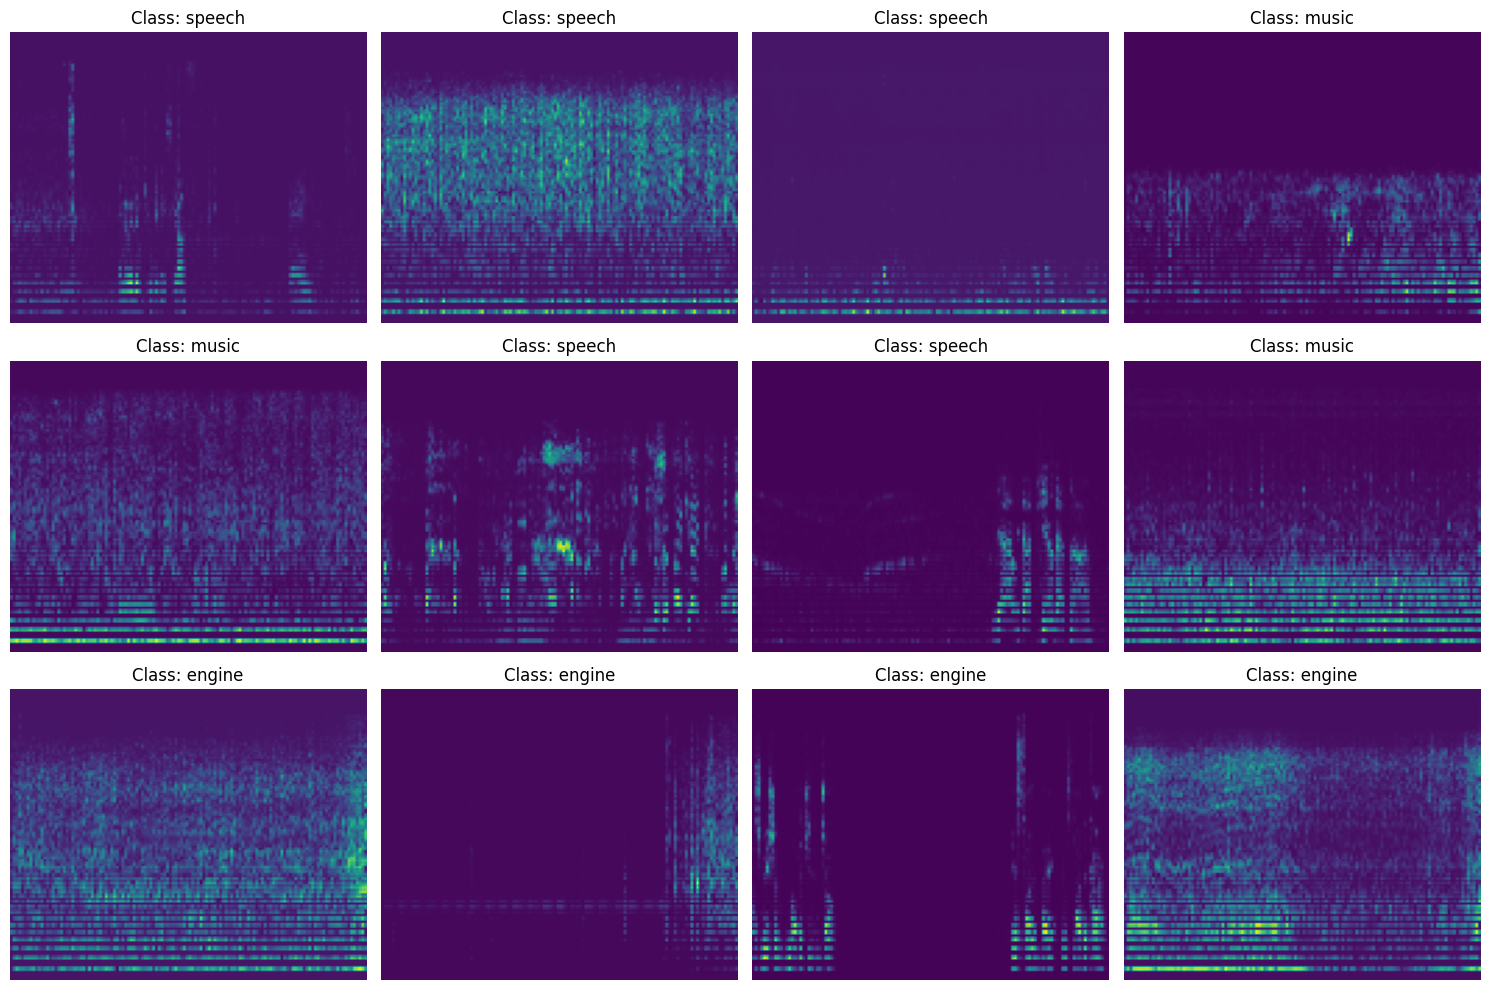

In [3]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random

def load_random_spectrograms(h5_file_path, num_samples=12):
    """
    Load a specified number of random spectrograms from an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.
        num_samples (int): Number of random spectrograms to load.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Random spectrograms and their corresponding labels.
    """
    with h5py.File(h5_file_path, "r") as hf:
        spectrograms = hf["spectrograms"][:]
        labels = hf["labels"][:]
        print(f"Total spectrograms in file: {spectrograms.shape[0]}")

        # Ensure we don't exceed the number of available samples
        num_samples = min(num_samples, spectrograms.shape[0])

        # Randomly select indices
        indices = random.sample(range(spectrograms.shape[0]), num_samples)
        random_spectrograms = spectrograms[indices]
        random_labels = labels[indices]

    return random_spectrograms, random_labels

def plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=None):
    """
    Plot spectrograms in a grid.

    Parameters:
        spectrograms (np.ndarray): Spectrogram data to plot.
        labels (np.ndarray): Corresponding labels.
        grid_shape (tuple): Shape of the grid (rows, cols).
        class_mapping (dict): Mapping of class indices to class names (optional).
    """
    rows, cols = grid_shape
    plt.figure(figsize=(15, 10))

    for i, (spec, label) in enumerate(zip(spectrograms, labels)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(spec, aspect="auto", origin="lower", cmap="viridis")
        title = f"Class: {label}" if class_mapping is None else f"Class: {class_mapping[label]}"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Path to HDF5 file
    h5_file_path = "./data/chunk_0.h5"  # Replace with your HDF5 file path

    # Class mapping for display (optional)
    class_mapping = {0: "engine", 1: "speech", 2: "music"}

    # Load 12 random spectrograms
    spectrograms, labels = load_random_spectrograms(h5_file_path, num_samples=12)

    # Plot the spectrograms
    plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=class_mapping)

## Prvotní pokus

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3177 - loss: 1.1003 - val_accuracy: 0.3307 - val_loss: 1.0990
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3343 - loss: 1.0989 - val_accuracy: 0.3288 - val_loss: 1.0989
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3319 - loss: 1.0987 - val_accuracy: 0.3307 - val_loss: 1.0990
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3301 - loss: 1.0987 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.3262 - loss: 1.0986 - val_accuracy: 0.3288 - val_loss: 1.0991
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3294 - loss: 1.0979 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3424 - loss: 1.0980 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3339 - loss: 1.0987 - val_accuracy: 0.328

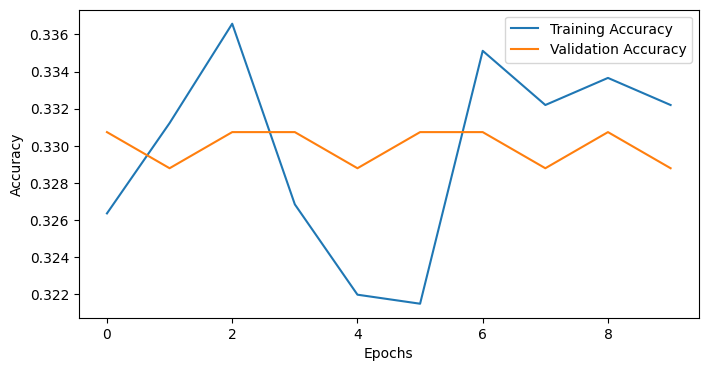

Model saved as 'flac_cnn_classifier.h5'


In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./audio_data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*input_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier.h5")
print("Model saved as 'flac_cnn_classifier.h5'")

## Základní model
### Popis modelu

- Kod je upraven pro rychlé zpracování na GPU
  - Data dostává v předzpracováné podobě a nahrává si je do paměti (vyčítání dat ze souboru je největším bottleneckem)
  - Využívá mixed_float16 pro rycheljší výpočty
  - Využívá JIT

- Oproti předchozímu modelu se změnil i způsob předzpracování dat a tvorby spectogramu
  - všechny zvuky byly zkráceny na stejnou délku resamplovány na stejnou frekvency 44100Hz a normalizovány na interval [0,1]
  - Vstupní data jsou ve formě Melova spectogramu resizováného na 128x128x1
    - Melův spectogram je typ spectogramu, který zohledňuje rozsah lidského ucha a upřednostňuje nižší frekvence před vysokými

In [11]:
!pip install --upgrade tensorflow keras wandb --quiet

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbCallback  # Correct import for WandbCallback

# --- Initialize Wandb ---
wandb.init(project="su2_noise_classification", name="simple_model")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")  # Use float16 for faster computation
tf.config.optimizer.set_jit(True)  # Enable XLA compilation for TensorFlow graphs

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    """
    Load spectrograms and labels from a single HDF5 file into memory and split into train/validation sets.
    """
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)  # No normalization
        labels = np.array(hf["labels"], dtype=np.int32)

    # Add channel dimension for Conv2D input
    spectrograms = spectrograms[..., np.newaxis]  # Shape: (samples, height, width, 1)
    num_classes = len(np.unique(labels))

    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )

    print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation Data Shape: {X_val.shape}, {y_val.shape}")
    return (X_train, y_train), (X_val, y_val), num_classes


# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"  # Path to your single HDF5 file
(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file, split=0.8)

# Initialize In-Memory Data Generators
batch_size = 32
train_generator = InMemoryDataGenerator(X_train, y_train, batch_size)
val_generator = InMemoryDataGenerator(X_val, y_val, batch_size)

# --- Step 4: Define the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Dynamically set num_classes
])

# Compile the model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Integrate Wandb Callback
wandb_callback = WandbCallback()

# --- Step 6: Train the Model ---
epochs = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping, wandb_callback]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# --- Finish Wandb Run ---
wandb.finish()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.7
    Uninstalling wandb-0.18.7:
      Successfully uninstalled wandb-0.18.7
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not 

Loading data from: ./data/chunk_0.h5
Training Data Shape: (2044, 128, 128, 1), (2044, 3)
Validation Data Shape: (512, 128, 128, 1), (512, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,491 (16.36 MB)

 Trainable params: 4,287,491 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'Node' object has no attribute 'inbound_layers'

Loading data from: ./data/chunk_0.h5
Training Data Shape: (2044, 128, 128, 1), (2044, 3)
Validation Data Shape: (512, 128, 128, 1), (512, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,491 (16.36 MB)

 Trainable params: 4,287,491 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.5132 - loss: 1.0041 - val_accuracy: 0.5625 - val_loss: 0.9461 - learning_rate: 5.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6068 - loss: 0.8629 - val_accuracy: 0.5879 - val_loss: 0.8670 - learning_rate: 5.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6617 - loss: 0.7739 - val_accuracy: 0.5898 - val_loss: 0.8832 - learning_rate: 5.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6974 - loss: 0.6928 - val_accuracy: 0.6074 - val_loss: 0.9269 - learning_rate: 5.0000e-04
Epoch 5/30
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7361 - loss: 0.6192
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7361 - loss: 0.6198 - val_accuracy: 0.6230 - val_loss: 0.9277 - learning_rate: 5.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7974 - loss: 0.5093 - va

Model saved as 'cnn_single_h5_model_no_norm.h5'


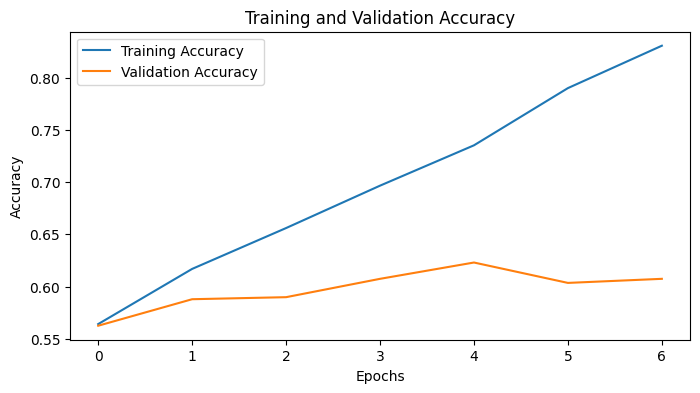

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")  # Use float16 for faster computation
tf.config.optimizer.set_jit(True)  # Enable XLA compilation for TensorFlow graphs

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    """
    Load spectrograms and labels from a single HDF5 file into memory and split into train/validation sets.

    Parameters:
        h5_file (str): Path to the HDF5 file.
        split (float): Train-validation split ratio.

    Returns:
        Tuple: (X_train, y_train), (X_val, y_val)
    """
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)  # No normalization
        labels = np.array(hf["labels"], dtype=np.int32)

    # Add channel dimension for Conv2D input
    spectrograms = spectrograms[..., np.newaxis]  # Shape: (samples, height, width, 1)
    num_classes = len(np.unique(labels))

    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )

    print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation Data Shape: {X_val.shape}, {y_val.shape}")
    return (X_train, y_train), (X_val, y_val)


# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        y_batch = self.y[batch_indices]
        return X_batch, y_batch

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"  # Path to your single HDF5 file
(X_train, y_train), (X_val, y_val) = load_single_h5_to_memory(h5_file, split=0.8)

# Initialize In-Memory Data Generators
batch_size = 32
train_generator = InMemoryDataGenerator(X_train, y_train, batch_size)
val_generator = InMemoryDataGenerator(X_val, y_val, batch_size)

# --- Step 4: Define the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_train.shape[1], activation='softmax')  # Dynamically set num_classes
])

# Compile the model
optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Step 6: Train the Model ---
epochs = 30
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_no_norm.h5")
print("Model saved as 'cnn_single_h5_model_no_norm.h5'")

# --- Step 8: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*input_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier.h5")
print("Model saved as 'flac_cnn_classifier.h5'")
